<a id='home'></a>
### purpose
    recreate figures from ../11_validate_GF_offset_predictions and ../09_RONA so that phenotypes are in the same figure and models organize the boxplot grouping, as opposed to how I did it previously by organizing figures by the model with multiple phenotypes organizing boxplot grouping
    
### outline

1. [load climate data](#climate)
    - get mahalanobis/geographic distance : pheno correlations
    
1. [load RONA data](#rona)
    - get RONA : pheno correlations
    
1. [load Gradient Forests data](#gf)
    - get Gradient Forests : pheno correlations

1. [create figs](#figs)
    1. [supp mat figs](#supp)
        - plot all locus and mahalanobis sources
    1. [main text figs](#main)
        - plot only baypass, wza, and wza-random sources, exclude mahalanobis distances calculated with all envs

In [1]:
from pythonimports import *
from myfigs import *
from matplotlib.lines import Line2D

phenodir = '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/phenotypes'
figdir = makedir('/data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs')

# from ../11_validate_GF_offset_predictions
txtdir = '/data/projects/pool_seq/phenotypic_data/offset_misc_files/results/gradient_forests'
# from ../09_RONA.ipynb
ronadir = '/data/projects/pool_seq/phenotypic_data/offset_misc_files/results/rona'

latest_commit()
sinfo(html=True)

##################################################################
Current commit of pythonimports:
commit b26ed2a7f602c6282ea35fc280b614a158a598c2  
Author: Brandon <brandon.lind@ubc.ca>  
Date:   Fri Nov 26 11:31:45 2021 -0700
Today:	December 08, 2021 - 14:25:24
python version: 3.8.5
##################################################################



<a id='climate'></a>
# load climate data

[top](#home)

In [2]:
# from ../08_climate_and_geographic_distance_vs_phenotypes.ipynb
# read in climatic and geographic distances to common garden
climate_geodf = pd.read_table('/data/projects/pool_seq/phenotypic_data/offset_misc_files/results/climate_geo_dist/climate_geo_dist.txt')
climate_geodf.head()

,spp,garden,pheno,distance_metric,spearman,pearson,rmse,rmse_mean,rmse_iq
0,jp,fontbrune,Mortality_2018,mahal_fontbrune_all,0.0265,0.0393,1011.5994,14.6138,60.5748
1,jp,fontbrune,Mortality_2018,mahal_fontbrune_cbst,0.0410,0.0849,52.4760,0.7581,3.1423
2,jp,fontbrune,Mortality_2018,mahal_fontbrune_cgdata,0.0149,0.0166,65.8580,0.9514,3.9436
3,jp,fontbrune,Mortality_2018,vincenty_fontbrune,0.0936,0.1729,919.2295,13.2794,55.0437
4,jp,fontbrune,Mean_Height_2018,mahal_fontbrune_all,0.0627,0.0569,536.6528,0.3355,4.9679


<a id='rona'></a>
# load rona data

[top](#home)

In [3]:
# from ../09_RONA.ipynb
rona_cordf = pd.read_table(op.join(ronadir, 'correlations.txt'))
print(rona_cordf.shape)
rona_cordf.head()

(1440, 12)


,spp,garden,method,setname,pheno,env,spearman,pearson,rmse,rmse_mean,rmse_iq,dataset
0,jp,christine,baypass,real,Mortality_2018,Elevation,0.1445,0.0999,77.4930,1.0065,5.8596,baypass-real
1,jp,christine,baypass,real,Mean_Height_2018,Elevation,0.0109,0.0294,1878.5391,1.0018,15.3768,baypass-real
2,jp,christine,baypass,real,Mean_DBH2018,Elevation,0.0171,0.0122,234.0658,1.0023,8.9449,baypass-real
3,jp,christine,baypass,real,Mortality_2018,MAT,0.0684,0.0666,77.4842,1.0064,5.8589,baypass-real
4,jp,christine,baypass,real,Mean_Height_2018,MAT,0.0330,0.0279,1878.5304,1.0018,15.3767,baypass-real


In [4]:
# from ../09_RONA.ipynb
efdict = pklload(op.join(ronadir, 'efdict.pkl'))

<a id='gf'></a>
# load GF data

- convert to dataframe like rona data

[top](#home)

In [5]:
# from ../11_validate_GF_offset_predictions
# load calculations
for obj in pbar(['offsets',
                 'validation_scores', 'validation_scores_twovariety', 'validation_scores_interior',
                 'cv', 'cv_twovariety', 'cv_interior',
                 'cv_scores', 'cv_scores_interior', 'cv_scores_twovariety']):
    
    pkl = op.join(txtdir, f'{obj}.pkl')
    
    globals()[obj] = pklload(pkl)

100%|██████████| 10/10 [00:00<00:00, 48.70it/s]


In [6]:
def get_remaining_stats(_dict, garden, _spp, dataset, kfold, pheno):
    stats = []
    for i,statistic in enumerate(statistics):
        val = _dict[statistic][garden][_spp][dataset][kfold][pheno][0]
        stats.append(val)
    return stats

In [7]:
# convert nested dictionary to dataframe in similar format as the `rona_cordf` above
primary_cols = ['spp', 'garden', 'model', 'method', 'setname', 'pheno', 'dataset', 'source', 'kfold']
statistics = ['pearson', 'spearman', 'rmse', 'rmse_mean', 'rmse_iq']

validation_df = pd.DataFrame(columns=primary_cols + statistics)

for _dict,dictname in zip([validation_scores, validation_scores_twovariety, validation_scores_interior],
                          ['validation_scores', 'validation_scores_twovariety', 'validation_scores_interior']):
    for garden,sppdict in _dict['pearson'].items():
        for _spp,datadict in sppdict.items():
            spp = _spp.split("-")[0]
            for dataset,kdict in datadict.items():
                method, setname = dataset.split('-')
                for kfold,phenodict in kdict.items():
                    for pheno,(pearson, pval) in phenodict.items():
                        stats = get_remaining_stats(_dict, garden,_spp,dataset,kfold,pheno)
                        validation_df.loc[nrow(validation_df)] = (
                            (spp, garden, _spp, method, setname, pheno, dataset, dictname, kfold, *stats)
                        )
validation_df.head()

,spp,garden,model,method,setname,pheno,dataset,source,kfold,pearson,spearman,rmse,rmse_mean,rmse_iq
0,combined,vancouver,combined,baypass,pseudo_random_loci,blup_increment,baypass-pseudo_random_loci,validation_scores,full,0.7925,0.7680,26.4770,1.0469,1.8842
1,combined,vancouver,combined,baypass,pseudo_random_loci,blup_shoot_biomass,baypass-pseudo_random_loci,validation_scores,full,0.7728,0.7316,10.0214,1.1270,1.2323
2,combined,vancouver,combined,baypass,pseudo_random_loci,blup_increment,baypass-pseudo_random_loci,validation_scores,k1,0.7377,0.6513,26.3734,1.0527,1.6590
3,combined,vancouver,combined,baypass,pseudo_random_loci,blup_shoot_biomass,baypass-pseudo_random_loci,validation_scores,k1,0.7920,0.6428,10.0868,1.1382,1.1866
4,combined,vancouver,combined,baypass,pseudo_random_loci,blup_increment,baypass-pseudo_random_loci,validation_scores,k2,0.7243,0.7109,25.0899,1.0458,2.4035


<a id='figs'></a>
# create figs

[top](#home)

In [8]:
# modified from ../11_validate_GF_offset_predictions

pretty_order = ['baypass-real',
                'baypass-pseudo_random_loci',
                'baypass-random',
                'wza-real',
                'wza-pseudo_random_loci',
                'wza-random']

short_order = ['baypass-real',
               'wza-real',
               'wza-random']

fontsize = 13.5
flierprops = dict(marker='d', markersize=5, markerfacecolor='none')


def pretty_pheno(pheno):
    """Update phenotype name to print pretty for figures."""
    return pheno.split()[0].replace('_', ' ').title().replace("Dbh", "DBH ").replace('Blup ', '').replace('Increment', 'Increment Growth')


def pretty_pheno(pheno):
    """Update phenotype name to print pretty for figures."""
    return pheno.split()[0].replace('_', ' ').title().replace("Dbh", "DBH ").replace('Blup ', '').replace('Increment', 'Increment Growth')


def pretty_fig(ax, validation_stat, spp, garden, phenos, exclude_phenos=[], numsource=None, ncol=3, pad=0):
    """Make the fig look rull pretty."""
    # fix legend - thanks https://stackoverflow.com/questions/35538882/seaborn-boxplot-stripplot-duplicate-legend
    handles, labels = ax.get_legend_handles_labels()
    labels = [
        label.replace('-set0', '').replace('-', ' ').replace('_', ' ').replace('loci', '')\
        .replace('full model', 'all populations')\
        .replace('baypass real', 'baypass')\
        .replace('wza real', 'WZA')\
        .replace('baypass pseudo random', 'pseudo random loci ($n$ = $n_{baypass}$)')\
        .replace('wza pseudo random', 'pseudo random loci ($n$ = $n_{WZA}$)')\
        .replace('baypass random', 'random loci ($n$ = $n_{baypass}$)')\
        .replace('wza random', 'random loci ($n$ = $n_{WZA}$)')
        for label in labels
    ]  # pretty labels
    keep_labels = []
    keep_handles = []
    for i,label in enumerate(labels):
        if label not in keep_labels:
            keep_labels.append(label)
            keep_handles.append(handles[i])

    l = plt.legend(keep_handles, keep_labels, ncol=ncol, loc='upper center', bbox_to_anchor=(0.5, 1.25+pad))
    l.set_title('Validation Source')
        
    stat = '$\\rho^2$' if validation_stat=='spearman' else '$r^2$' if validation_stat=='pearson' else ''
    ydict = {'spearman' : f"validation score ({validation_stat.capitalize()}'s {stat})",
             'pearson' : f"validation score ({validation_stat.capitalize()}'s {stat})",
             'rmse' : 'validation score (RMSE)',
             'rmse_mean' : 'validation score (mean-normalized RMSE)',
             'rmse_iq' : 'validation score (interquartile-normalized RMSE)'
            }
    plt.ylabel(ydict[validation_stat],
               fontdict={'fontsize': fontsize})
    if 'rmse' not in validation_stat:
        plt.ylim((-0.03, 1.03))
        
    pass


metric_viz = {'mahal_christine_all' : ('blue', ':'),
              'mahal_christine_cgdata' : ('dodgerblue', '--'),
              'mahal_christine_cbst' : ('deepskyblue', '-.'),
              'mahal_fontbrune_all' : ('blue', ':'),
              'mahal_fontbrune_cgdata' : ('dodgerblue', '--'),
              'mahal_fontbrune_cbst' : ('deepskyblue', '-.'),
              'mahal_vancouver_all' : ('blue', '-'),
              'mahal_vancouver_cgdata' : ('dodgerblue', '--'),
              'mahal_vancouver_cbst' : ('deepskyblue', '-.'),
              'vincenty_christine' : ('red', '--'),
              'vincenty_fontbrune' : ('red', '--'),
              'vincenty_vancouver' : ('red', '--')}

metricnames = {'mahal_christine_all' : "Mahalanobis climate distance (all envs)",
               'mahal_christine_cgdata' : "Mahalanobis climate distance (provenance trial envs)",
               'mahal_christine_cbst' : "Mahalanobis climate distance (CBST envs)",
               'mahal_fontbrune_all' : "Mahalanobis climate distance (all envs)",
               'mahal_fontbrune_cgdata' : "Mahalanobis climate distance (provenance trial envs)",
               'mahal_fontbrune_cbst' : "Mahalanobis climate distance (CBST envs)",
               'mahal_vancouver_all' : "Mahalanobis climate distance (all envs)",
               'mahal_vancouver_cgdata' : "Mahalanobis climate distance (provenance trial envs)",
               'mahal_vancouver_cbst' : "Mahalanobis climate distance (CBST envs)",
               'vincenty_christine' : "Vincenty's geodesic",
               'vincenty_fontbrune' : "Vincenty's geodesic",
               'vincenty_vancouver' : "Vincenty's geodesic"}


def create_boxplot(figuredf, fulldf, spp, garden, pheno, saveloc=None, exclude_phenos=[], validation_stat='spearman',
                   numsource=None, title=None, mycolors=None, ncol=4, pad=0, figsize=(15.7, 6)):
    
    sns.set(rc={'figure.figsize':figsize})

    # create boxplot
    firstcol = figuredf.columns.values[0]
    sns.boxplot(x=firstcol, y='value', data=figuredf, hue='Validation Source', flierprops=flierprops,
                palette=mycolors)

    # add in full value from `fulldf`
    ax = sns.stripplot(
        x=firstcol, y='value', data=fulldf, hue='Validation Source', dodge=True, jitter=False,
        linewidth=0.5, edgecolor='k', size=8, marker='^', label='full model', color='k'
    )
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)
    spporder = [x.get_text() for x in ax.xaxis.get_majorticklabels()]
    if spp != 'jp':
        spporder = [order.split()[-1].split('-')[0] for order in spporder]
#     print(f'{spporder = }')

    
    # set up dashed line data for geographic and climate distance (use spp.split to account for eg `eastern-combined`)
    if spp != 'jp':
        cdf = climate_geodf[(climate_geodf['spp'].isin(spporder)) &
                            (climate_geodf['garden']==garden) &
                            (climate_geodf['pheno']==pheno)].copy()
    else:
        cdf = climate_geodf[(climate_geodf['spp']=='jp') &
                            (climate_geodf['garden']==garden) &
                            (climate_geodf['pheno']==pheno)].copy()
#     print(f'{nrow(cdf) = }')
    if len(mycolors) < 6:
        # if making simplified figures, remove the mahalanobis distance metrics using all climate envs
        cdf = cdf[~cdf['distance_metric'].str.contains('all')]
    cdf['pheno'] = cdf['pheno'].apply(lambda pheno: pretty_pheno(pheno))
    
    x = pd.Series([0.5, 1.5])  # straddle center
    if spp != 'jp':
        for _spp_,factor in zip(spporder, range(-1, len(spporder))):
            xfactor = x + factor
            pdf = cdf[cdf['spp']==_spp_]
            for row in pdf.index:
                metric = pdf.loc[row, 'distance_metric']
                color,linestyle = metric_viz[metric]
                y = pd.Series(pdf.loc[row, validation_stat])
                line = Line2D(xfactor, y, color=color, linestyle=linestyle, zorder=0, label=metricnames[metric])
                ax.add_line(line)
    else:
        for method,factor in zip(spporder, range(-1, len(spporder))):
            xfactor = x + factor
            pdf = cdf[cdf['pheno']==pretty_pheno(pheno)]
            for row in pdf.index:
                metric = pdf.loc[row, 'distance_metric']
                color,linestyle = metric_viz[metric]
                y = pd.Series(pdf.loc[row, validation_stat])
                line = Line2D(xfactor, y, color=color, linestyle=linestyle, zorder=0, label=metricnames[metric])
                ax.add_line(line)

    # make it rull pretty
    if len(mycolors) > 3:
        pad += 0.08
    pretty_fig(ax,
               validation_stat,
               spp,
               garden,
               uni(cdf['pheno']),
               exclude_phenos=exclude_phenos,
               numsource=numsource,
               ncol=ncol,
               pad=pad)
    plt.title(title)

#     if save is True:
#         all_phenos = True if len(exclude_phenos)==0 else False if spp != 'jp' else True
#         saveloc = op.join(figdir, f'{spp}_{garden}_{pheno}_{validation_stat}_GF.pdf')
#         save_pdf(saveloc)
    if saveloc is not None:
        save_pdf(saveloc)

    plt.show()

    pass


def _blankdf(garden, spp, pheno):
    sptrans = {'eastern' : 'Eastern subgroup of Interior Douglas-fir',
               'western' : 'Western subgroup of Interior Douglas-fir',
               'fdi' : 'Interior Douglas-fir',
               'fdc' : 'Coastal Douglas-fir',
               'jp' : 'Jack pine',
               'combined' : 'Coastal & Interior Douglas-fir',
               'western-fdi' : 'Western Genetic Group of Interior Douglas-fir from Interior Model',
               'western-combined' : 'Western Genetic Group of Interior Douglas-fir from Full-variety Model',
               'eastern-combined' : 'Eastern Genetic Group of Interior Douglas-fir from Full-variety model',
               'fdc-combined' : 'Coastal Variety of Douglas-fir from Full-variety model',
               'fdi-combined' : 'Interior Variety of Douglas-fir from Full-variety model',
               'eastern-fdi': 'Eastern Genetic Group of Interior Douglas-fir from Interior Model'
              }
    gtrans = {'fontbrune' : 'Fontbrune',
              'christine' : "Ste-Christine-d'Auvergne",
              'vancouver': "Vancouver"}
    blankdf = pd.DataFrame(columns=[f'\n{sptrans[spp]} {pheno} at {gtrans[garden]} common garden',
                                    'Validation Source',
                                    'value'])

    return blankdf


In [9]:
def recreate_doug_boxplots(groups=pretty_order, colors=None, ncol=4):
    """Recreate doug-fir boxplots from ../11.ipynb and ../09.ipynb to group phenotypes instead of model origins.
    
    Parameters
    ----------
    - groups : the locus groups to use when creating boxplots
    """
    locus_groups = 'allgroups' if groups==pretty_order else 'smallgroups'
    
    for pheno in ['blup_shoot_biomass', 'blup_increment']:
        _pheno = pretty_pheno(pheno)
        gf = validation_df[validation_df['pheno']==pheno].copy()
        rona = rona_cordf[rona_cordf['pheno']==pheno].copy()

        # create new combined fig
        figuredf = _blankdf('vancouver', 'combined', _pheno)
        fulldf = _blankdf('vancouver', 'combined', _pheno)
        _gf = gf[gf['spp']=='combined'].copy()
        _rona = rona[(rona['spp']=='combined') & 
                     (rona['env'].isin(efdict['canonical']['combined']['vancouver']))].copy()

        for dataset in groups:
            # gradient forest data
            _full = _gf[(_gf['kfold']=='full') & (_gf['dataset']==dataset)]
            _kfold = _gf[(_gf['kfold']!='full') & (_gf['dataset']==dataset)]
            for r2 in _kfold['spearman']:
                figuredf.loc[nrow(figuredf)] = 'Gradient Forests combined', dataset, r2
            full_val = _full['spearman'].iloc[0]
            fulldf.loc[nrow(fulldf)] = 'Gradient Forests combined', dataset, full_val
            # rona data
            _ronadata = _rona[_rona['dataset']==dataset]
            for row in _ronadata.index:
                figuredf.loc[nrow(figuredf)] = 'RONA combined', dataset, _ronadata.loc[row, 'spearman']
            for i,source in enumerate(fulldf['Validation Source']):
                fulldf.loc[nrow(fulldf)] = 'RONA combined', source, np.nan

        saveloc = op.join(figdir, f'combined_vancouver_{pheno}_spearman_GF_{locus_groups}.pdf')
        create_boxplot(figuredf, fulldf, 'combined', 'vancouver', pheno, saveloc=saveloc, mycolors=colors,
                       ncol=ncol)
        

        # create plot using variety
        coastal = ['fdc-combined', 'fdc']
        interior = ['fdi-combined', 'fdi']
        eastern = ['eastern-combined', 'eastern-fdi']
        western = ['western-combined', 'western-fdi']
        for variety,varname in zip([coastal, interior, eastern, western], ['fdc', 'fdi', 'eastern', 'western']):        
            figuredf = _blankdf('vancouver', varname, _pheno)
            fulldf = _blankdf('vancouver', varname, _pheno)
            for model in variety:
                _gf = gf[gf['model']==model]
                if '-' in model:
                    _rona = pd.DataFrame(columns=rona.columns)
                else:
                    _rona = rona[(rona['spp']==model.split('-')[-1]) & 
                                 (rona['env'].isin(efdict['canonical'][model]['vancouver']))]
    #             print(model, f'{nrow(_gf) = }', f'{nrow(_rona) = }')
                for dataset in groups:
                    _full = _gf[(_gf['kfold']=='full') & (_gf['dataset']==dataset)].copy()
                    _kfold = _gf[(_gf['kfold']!='full') & (_gf['dataset']==dataset)].copy()
                    for r2 in _kfold['spearman']:
                        figuredf.loc[nrow(figuredf)] = f'Gradient Forests {model}', dataset, r2
                    full_val = _full['spearman'].iloc[0]
                    fulldf.loc[nrow(fulldf)] = f'Gradient Forests {model}', dataset, full_val
                    # rona data
                    if nrow(_rona) > 0:
                        _ronadata = _rona[_rona['dataset']==dataset].copy()
                        for row in _ronadata.index:
                            figuredf.loc[nrow(figuredf)] = f'RONA {model}', dataset, _ronadata.loc[row, 'spearman']
                        for i,source in enumerate(fulldf['Validation Source']):
                            fulldf.loc[nrow(fulldf)] = f'RONA {model}', source, np.nan

            saveloc = op.join(figdir, f'{varname}_vancouver_{pheno}_spearman_GF_{locus_groups}.pdf')
            create_boxplot(figuredf, fulldf, varname, 'vancouver', pheno, saveloc=saveloc, mycolors=colors,
                           ncol=ncol)
            
    pass


In [10]:
def recreate_jack_boxplots(groups=pretty_order, colors=None, ncol=4, figsize=(15.7, 6)):
    """Recreate jack pine boxplots from ../11.ipynb and ../09.ipynb to group phenotypes instead of model origins.
    
    Parameters
    ----------
    - groups : the locus groups to use when creating boxplots
    """
    locus_groups = 'allgroups' if groups==pretty_order else 'smallgroups'
    
    for garden in ['christine', 'fontbrune']:
        for pheno in ['Mean_DBH2018', 'Mortality_2018', 'Mean_Height_2018']:
            _pheno = pretty_pheno(pheno)
            gf = validation_df[(validation_df['pheno']==pheno) & (validation_df['garden']==garden)].copy()
            rona = rona_cordf[(rona_cordf['pheno']==pheno) & (rona_cordf['garden']==garden)].copy()

            # create new combined fig
            figuredf = _blankdf(garden, 'jp', _pheno)
            fulldf = _blankdf(garden, 'jp', _pheno)
            _gf = gf[gf['spp']=='jp'].copy()
            _rona = rona[(rona['spp']=='jp') & 
                         (rona['env'].isin(efdict['canonical']['jp'][garden]))].copy()

            for dataset in groups:
                # gradient forest data
                _full = _gf[(_gf['kfold']=='full') & (_gf['dataset']==dataset)]
                _kfold = _gf[(_gf['kfold']!='full') & (_gf['dataset']==dataset)]
                for r2 in _kfold['spearman']:
                    figuredf.loc[nrow(figuredf)] = 'Gradient Forests', dataset, r2
                full_val = _full['spearman'].iloc[0]
                fulldf.loc[nrow(fulldf)] = 'Gradient Forests', dataset, full_val
                # rona data
                _ronadata = _rona[_rona['dataset']==dataset]
                for row in _ronadata.index:
                    figuredf.loc[nrow(figuredf)] = 'RONA', dataset, _ronadata.loc[row, 'spearman']
                for i,source in enumerate(fulldf['Validation Source']):
                    fulldf.loc[nrow(fulldf)] = 'RONA', source, np.nan

            saveloc = op.join(figdir, f'jp_{garden}_{pheno}_spearman_GF_{locus_groups}.pdf')
            create_boxplot(figuredf, fulldf, 'jp', garden, pheno, saveloc=saveloc, mycolors=colors,
                           ncol=ncol, figsize=figsize)
    pass

<a id='supp'></a>
### all loci groups

[top](#home)

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/combined_vancouver_blup_shoot_biomass_spearman_GF_allgroups.pdf


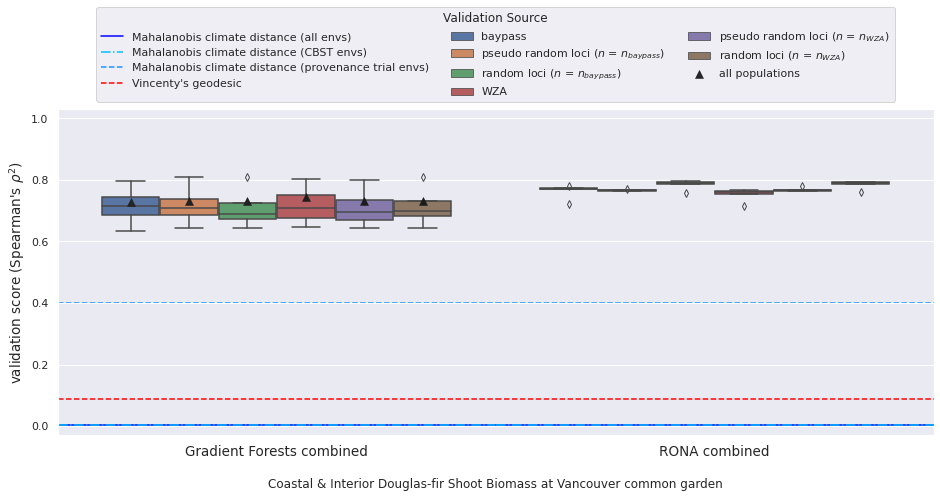

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/fdc_vancouver_blup_shoot_biomass_spearman_GF_allgroups.pdf


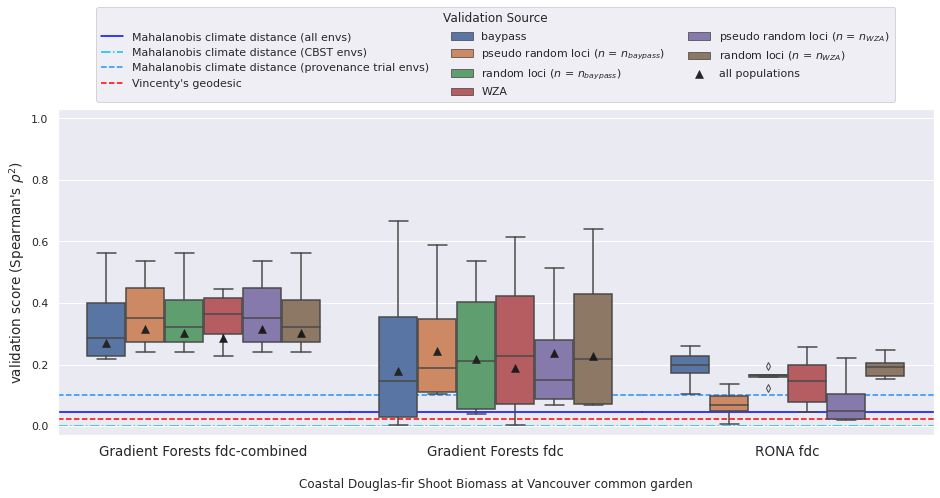

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/fdi_vancouver_blup_shoot_biomass_spearman_GF_allgroups.pdf


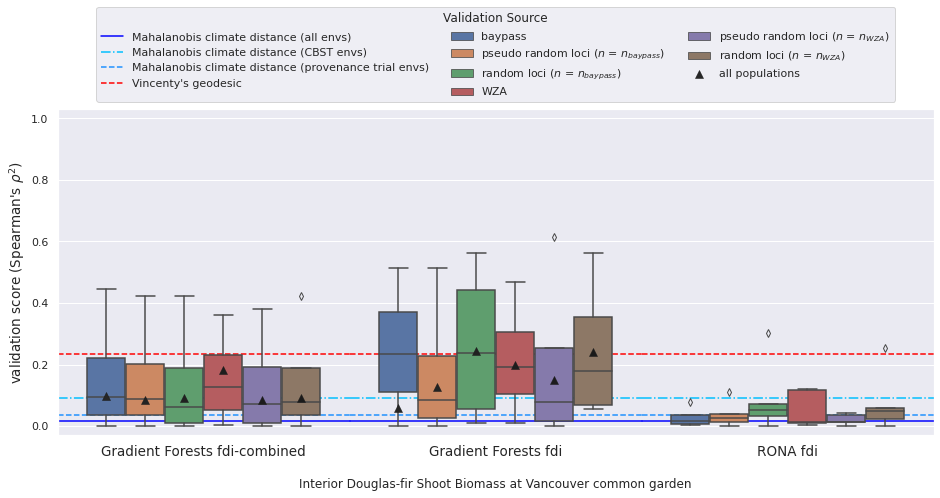

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/eastern_vancouver_blup_shoot_biomass_spearman_GF_allgroups.pdf


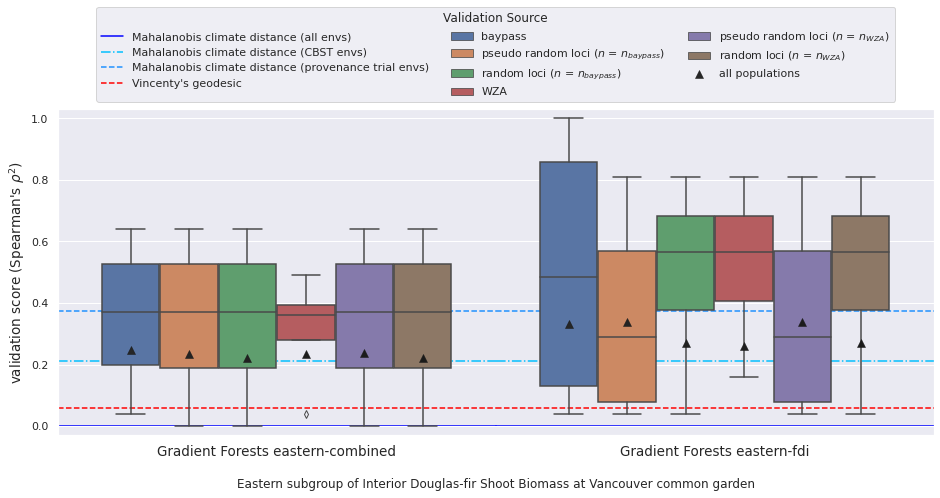

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/western_vancouver_blup_shoot_biomass_spearman_GF_allgroups.pdf


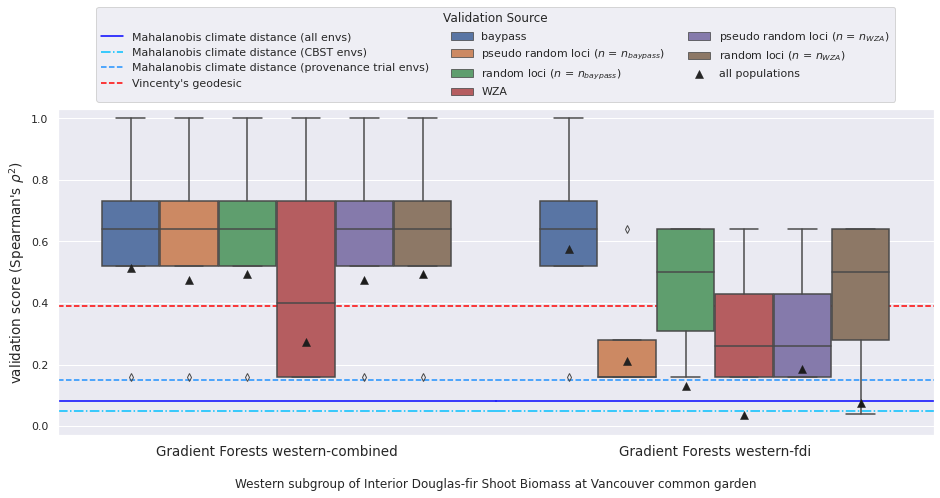

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/combined_vancouver_blup_increment_spearman_GF_allgroups.pdf


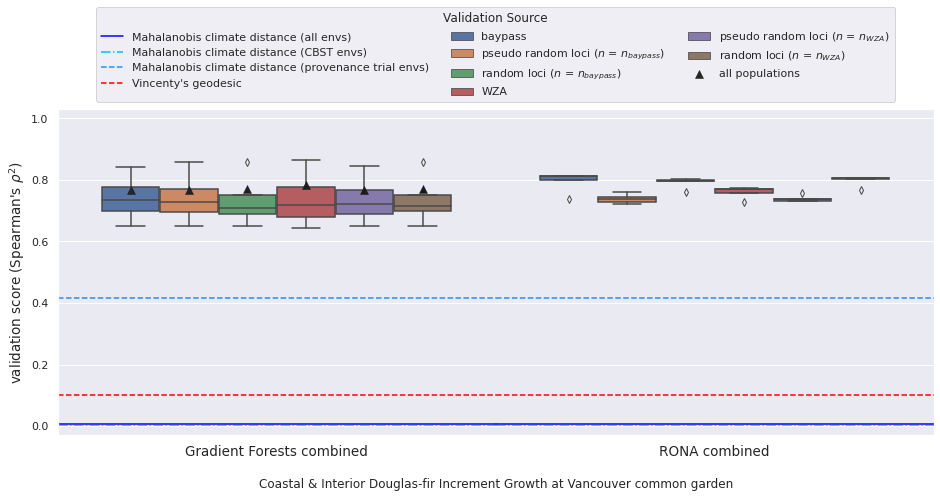

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/fdc_vancouver_blup_increment_spearman_GF_allgroups.pdf


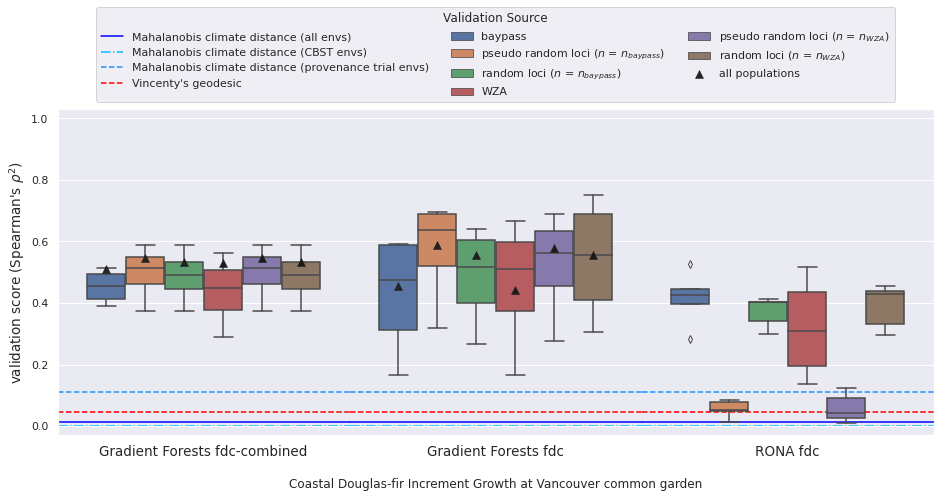

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/fdi_vancouver_blup_increment_spearman_GF_allgroups.pdf


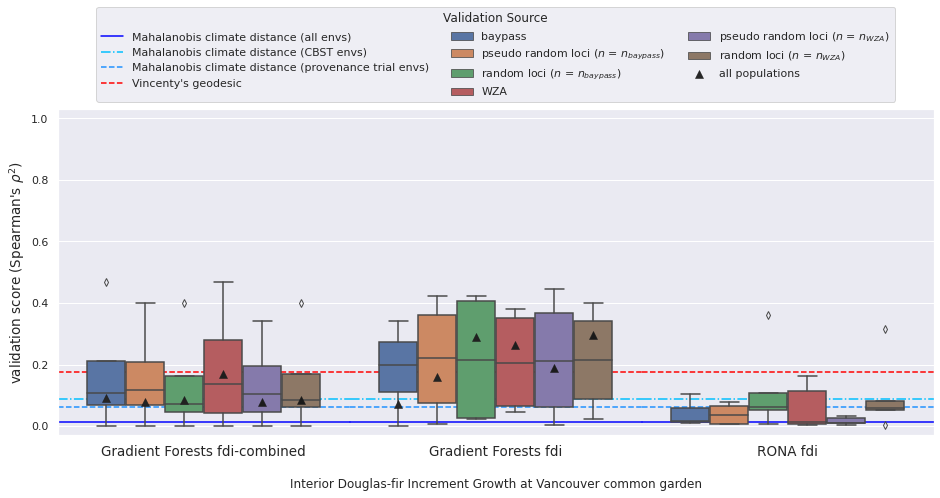

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/eastern_vancouver_blup_increment_spearman_GF_allgroups.pdf


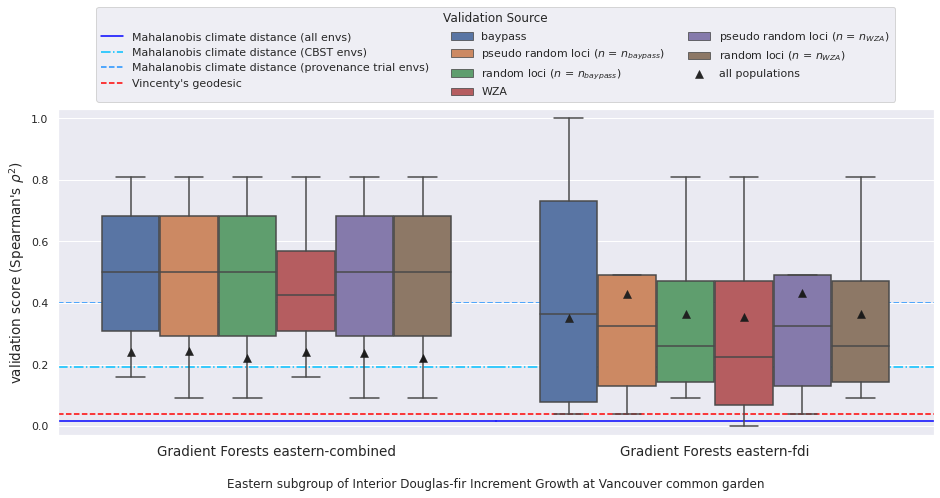

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/western_vancouver_blup_increment_spearman_GF_allgroups.pdf


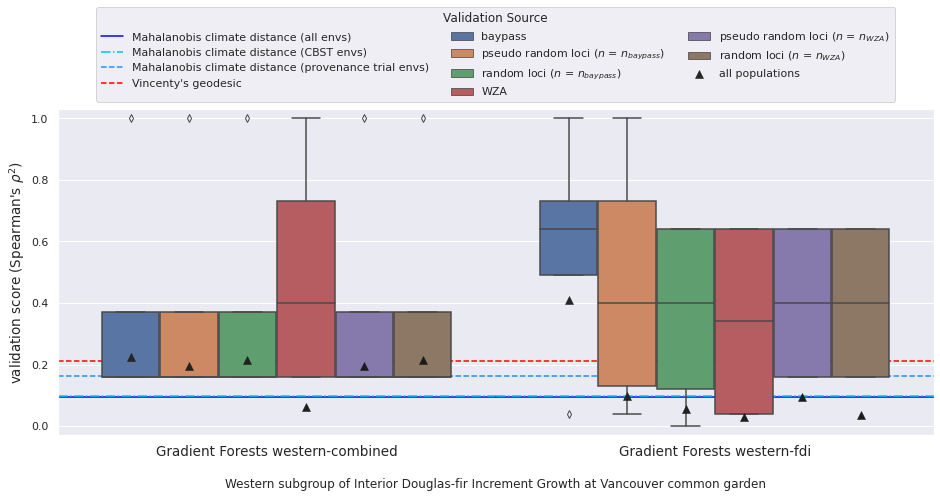

In [16]:
# for whatever reason I had to rerun this cell after all cells completed so that I didn't get bold colors 🤷‍♂️
recreate_doug_boxplots(groups=pretty_order, colors=sns.color_palette(), ncol=3)

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/jp_christine_Mean_DBH2018_spearman_GF_allgroups.pdf


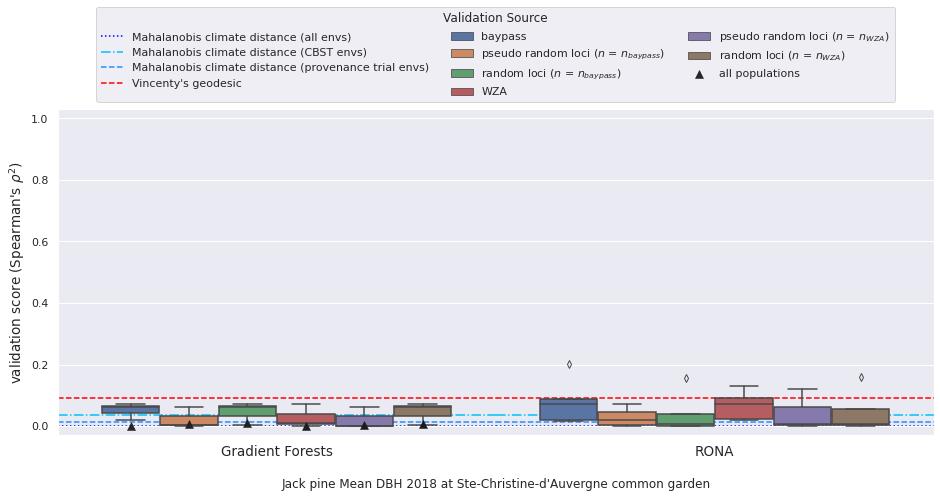

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/jp_christine_Mortality_2018_spearman_GF_allgroups.pdf


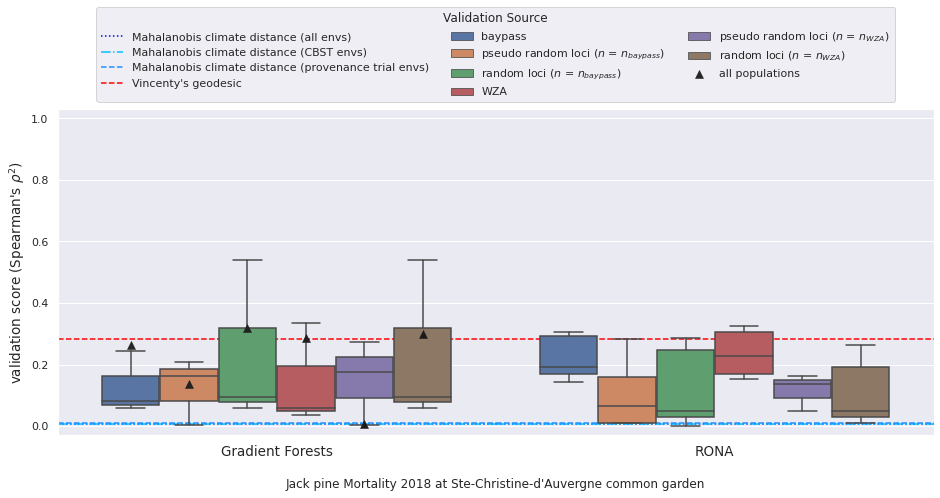

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/jp_christine_Mean_Height_2018_spearman_GF_allgroups.pdf


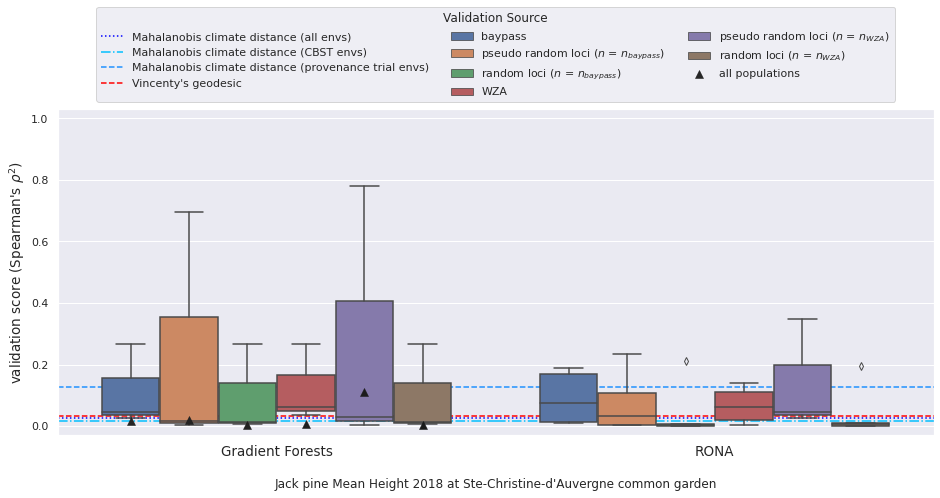

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/jp_fontbrune_Mean_DBH2018_spearman_GF_allgroups.pdf


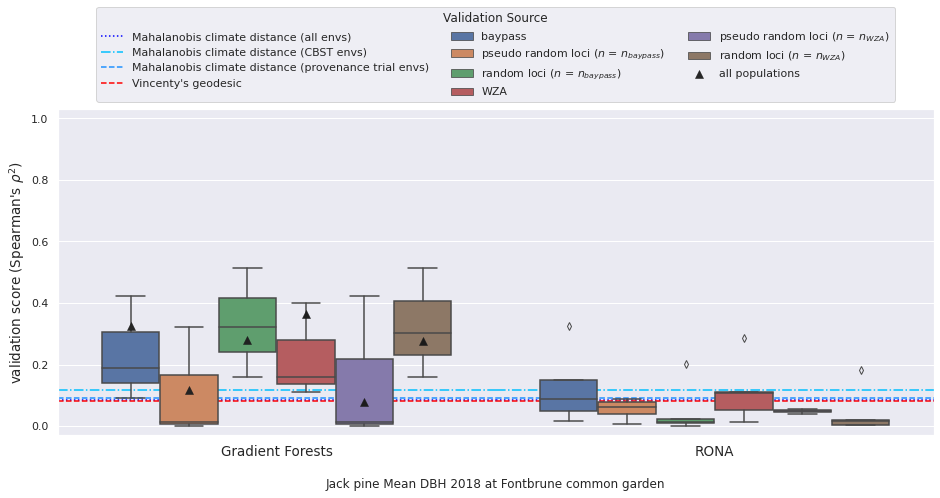

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/jp_fontbrune_Mortality_2018_spearman_GF_allgroups.pdf


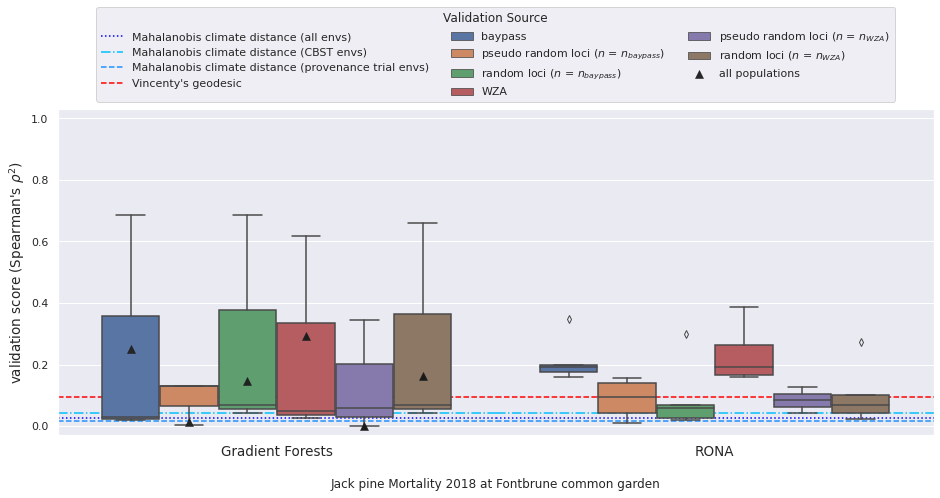

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/jp_fontbrune_Mean_Height_2018_spearman_GF_allgroups.pdf


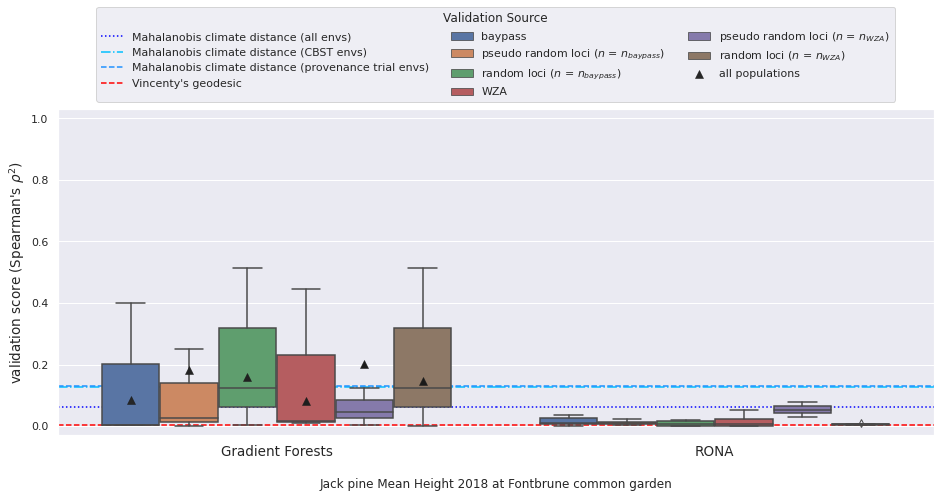

In [12]:
recreate_jack_boxplots(groups=pretty_order, colors=sns.color_palette(), ncol=3)

<a id='main'></a>
### main text

[top](#home)

In [13]:
# double check colors for baypass, wza, and wza-random
for color in [sns.color_palette()[0], sns.color_palette()[3], sns.color_palette()[5]]:
    print(ColorText('color').custom(color).bold())

color
color
color


Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/combined_vancouver_blup_shoot_biomass_spearman_GF_smallgroups.pdf


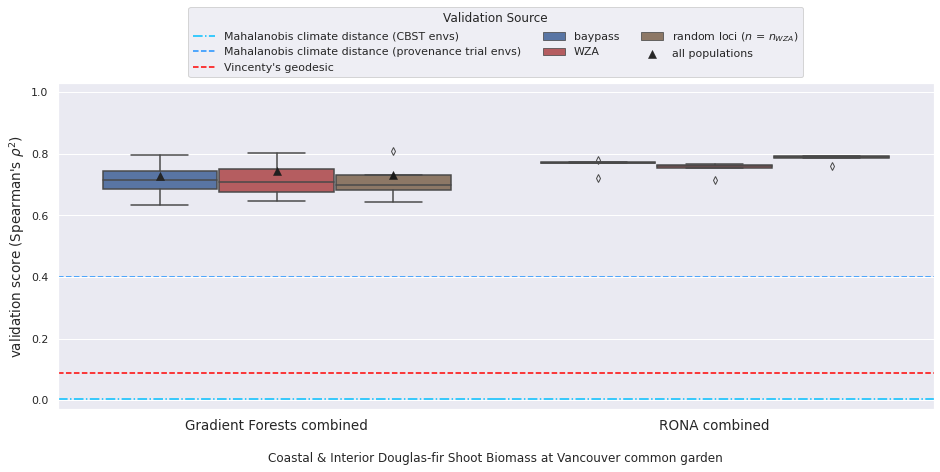

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/fdc_vancouver_blup_shoot_biomass_spearman_GF_smallgroups.pdf


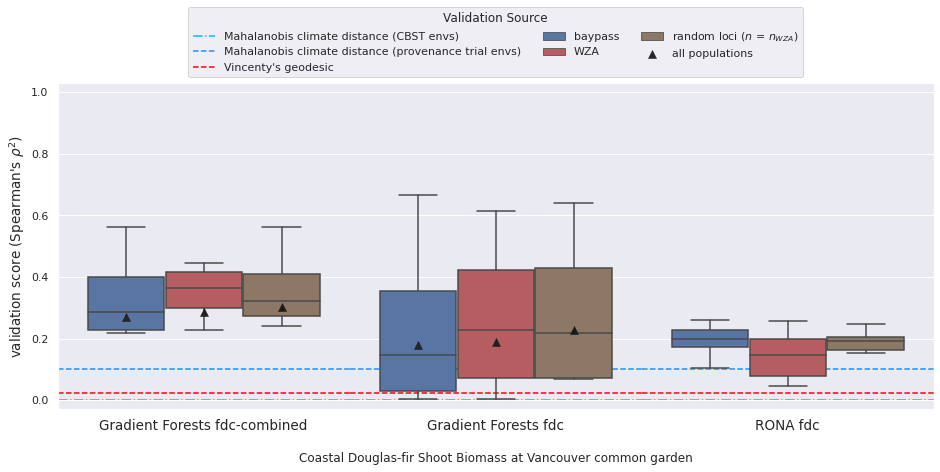

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/fdi_vancouver_blup_shoot_biomass_spearman_GF_smallgroups.pdf


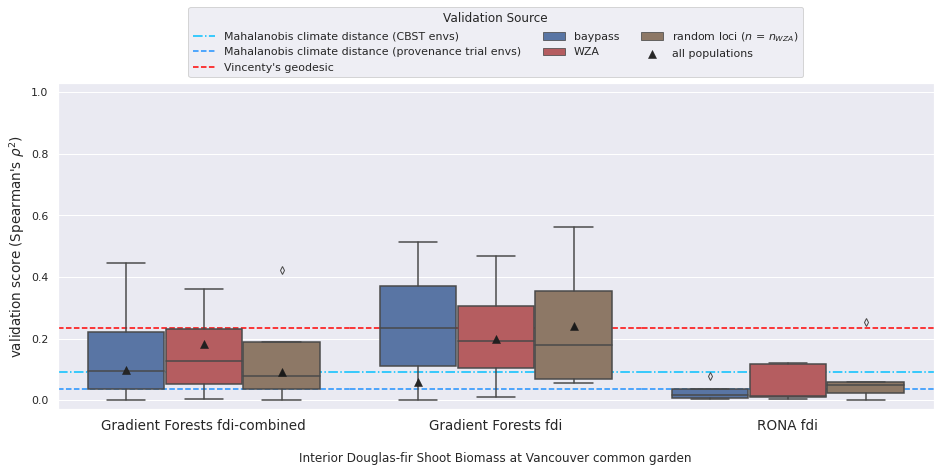

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/eastern_vancouver_blup_shoot_biomass_spearman_GF_smallgroups.pdf


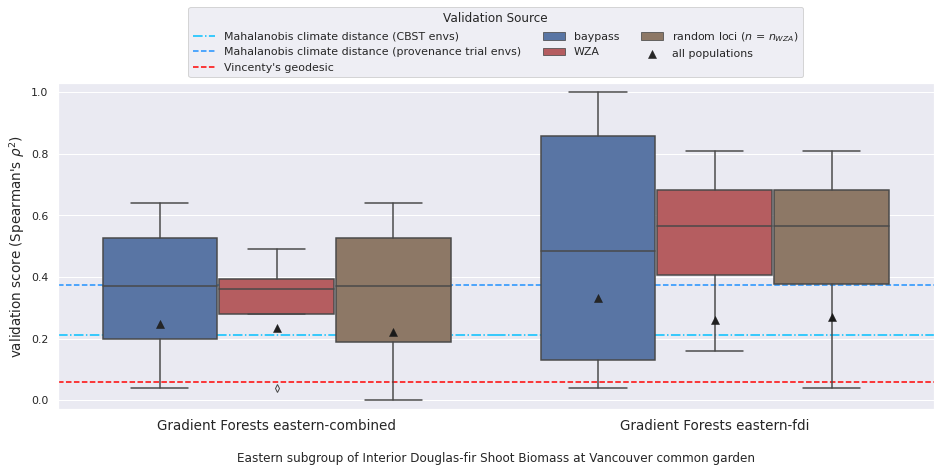

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/western_vancouver_blup_shoot_biomass_spearman_GF_smallgroups.pdf


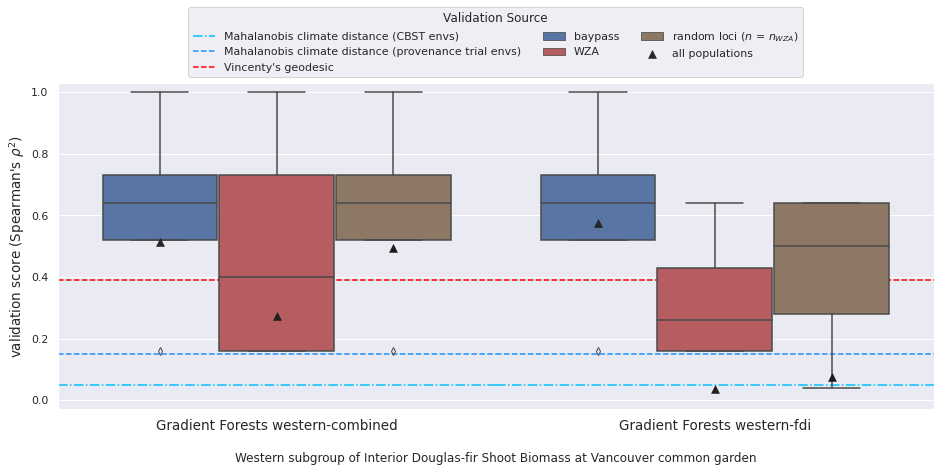

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/combined_vancouver_blup_increment_spearman_GF_smallgroups.pdf


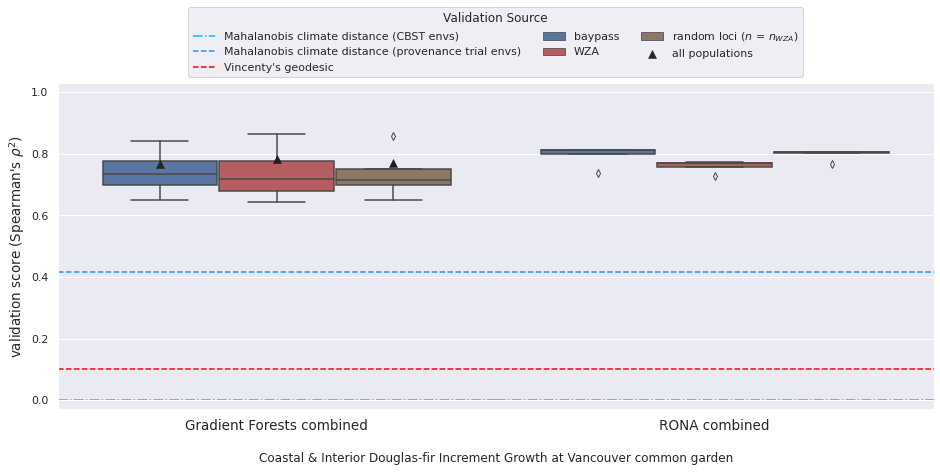

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/fdc_vancouver_blup_increment_spearman_GF_smallgroups.pdf


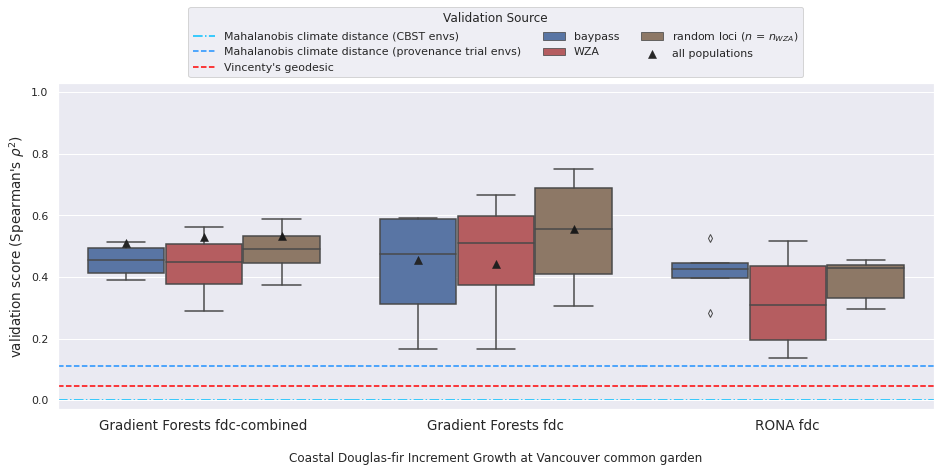

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/fdi_vancouver_blup_increment_spearman_GF_smallgroups.pdf


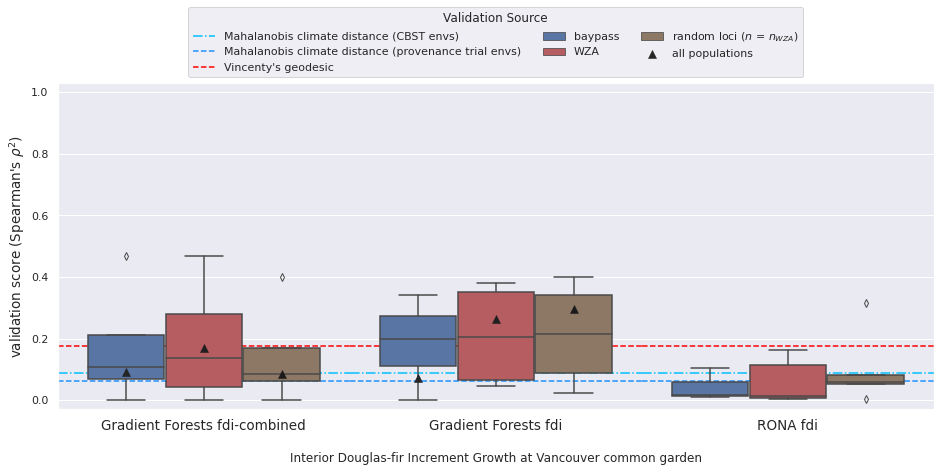

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/eastern_vancouver_blup_increment_spearman_GF_smallgroups.pdf


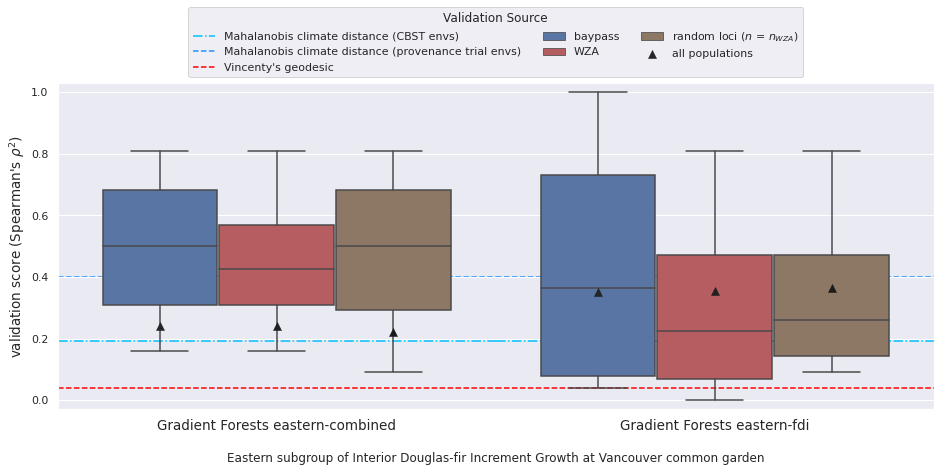

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/western_vancouver_blup_increment_spearman_GF_smallgroups.pdf


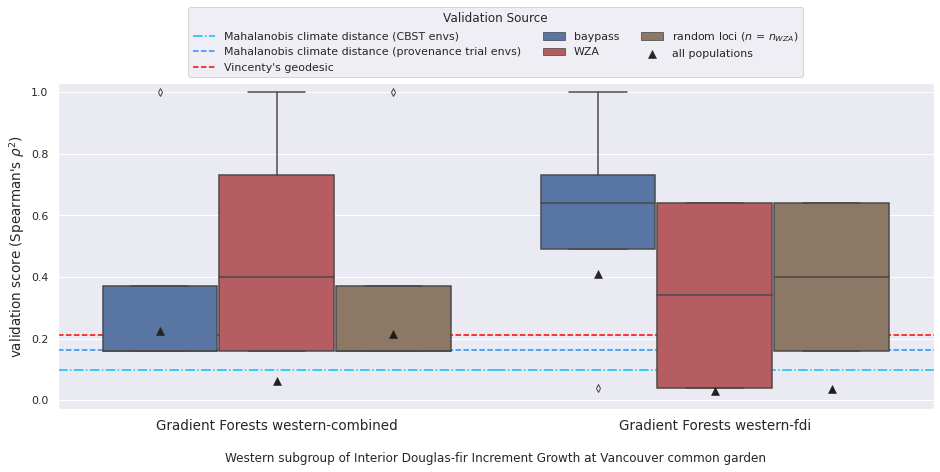

In [14]:
recreate_doug_boxplots(groups=short_order,
                       colors=[sns.color_palette()[0], sns.color_palette()[3], sns.color_palette()[5]],
                       ncol=3)

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/jp_christine_Mean_DBH2018_spearman_GF_smallgroups.pdf


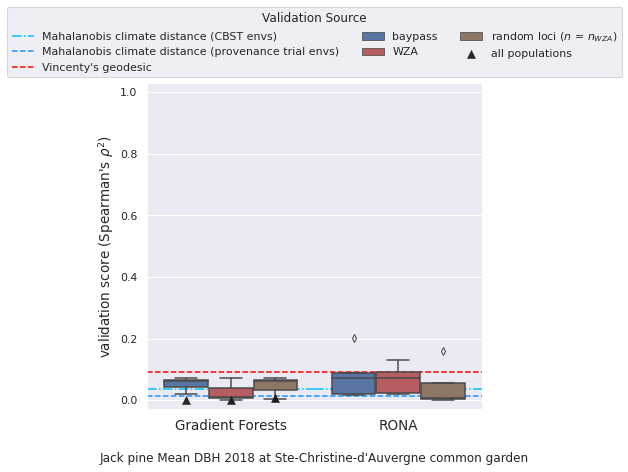

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/jp_christine_Mortality_2018_spearman_GF_smallgroups.pdf


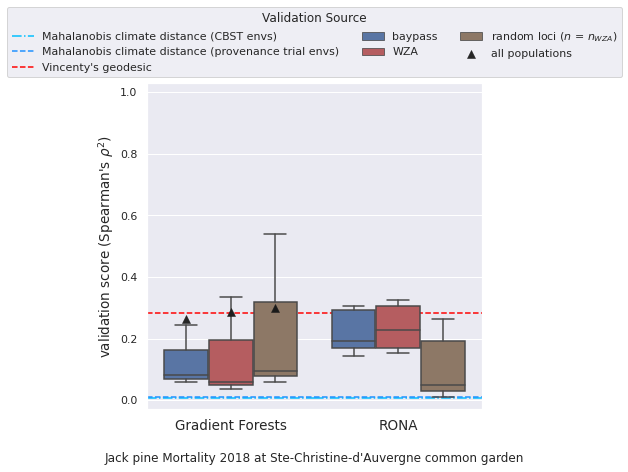

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/jp_christine_Mean_Height_2018_spearman_GF_smallgroups.pdf


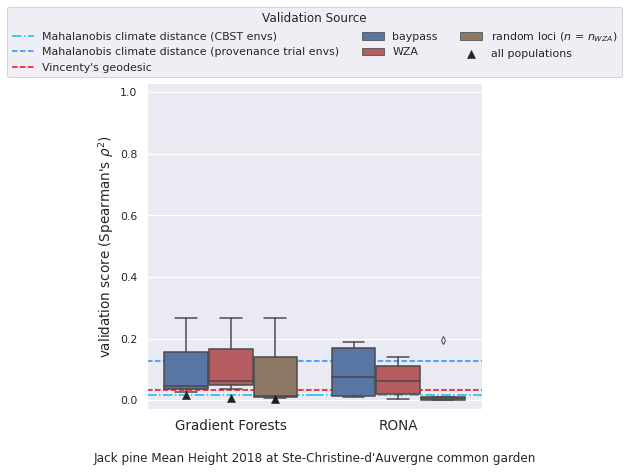

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/jp_fontbrune_Mean_DBH2018_spearman_GF_smallgroups.pdf


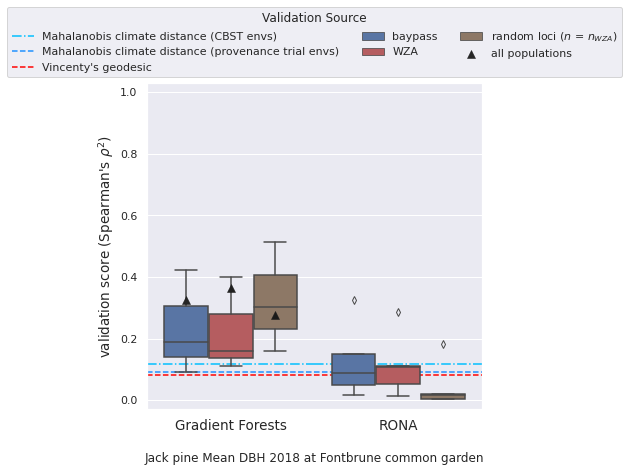

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/jp_fontbrune_Mortality_2018_spearman_GF_smallgroups.pdf


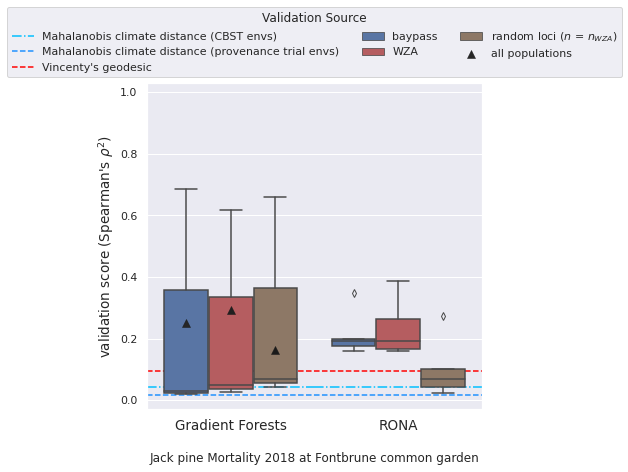

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/new_figs/jp_fontbrune_Mean_Height_2018_spearman_GF_smallgroups.pdf


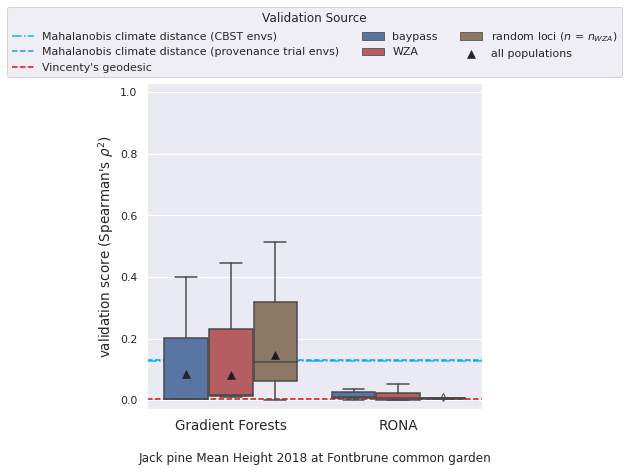

In [15]:
recreate_jack_boxplots(groups=short_order,
                       colors=[sns.color_palette()[0], sns.color_palette()[3], sns.color_palette()[5]],
                       ncol=3, figsize=(6, 6))